In [3]:
import seaborn as sns
import pickle
import pandas as pd
import glob
import re
import matplotlib.pylab as plt
%matplotlib inline

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [4]:
sil_scores = pickle.load(open("../results/clustering/results/MFC/clust_k_1_15_id.pkl", "r"))
sil_scores = pd.DataFrame(zip(sil_scores, range(2, len(sil_scores)+2)), columns=['sil', 'k'])
sil_scores['type'] = 'real'

In [8]:
results = {}
for f in glob.glob('../results/clustering/results/MFC/perm_clust_k*'):
    try:
        df = pd.DataFrame(pickle.load(open(f, 'r')), columns=['sil'])
        df['k'] = int(re.findall('k[0-9]*', f)[0][1:])
        df['type'] = 'perm'
        sil_scores = sil_scores.append(df)
    except:
        pass


In [9]:
sil_scores[sil_scores.type == 'perm'].groupby(('k', 'type')).count()

,,sil
k,type,
2,perm,500
3,perm,500
4,perm,500
5,perm,500
6,perm,500
7,perm,500
8,perm,500
9,perm,700
10,perm,600


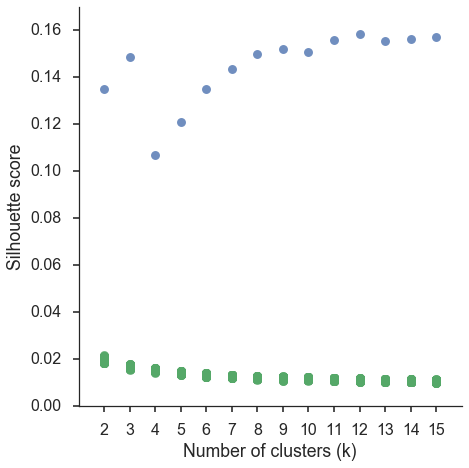

In [18]:
sns.set_context('poster')
sns.set_style('ticks')
sns.despine(left=True)
sns.lmplot('k', 'sil', sil_scores, hue='type', fit_reg=False, size=7, legend=False, scatter_kws={"s": 80})
plt.ylim([0, 0.17])
plt.xlim([1, 16])
plt.xticks(range(2, 16))
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette score')
plt.savefig('../reports/MFC/mFC_Shared/Figures/Figure2c.png', bbox_inches='tight')


In [10]:
mean_z = [float((sil_scores.query('k == ' + str(i) +'and type == "real"').sil -sil_scores.query('k == ' + str(i) +'and type == "perm"').sil.mean()) /sil_scores.query('k == ' + str(i) +' and type == "perm"').sil.std())
 for i in [3, 6, 9, 12]]
zs = pd.DataFrame(zip(mean_z, [3, 6, 9, 12]), columns=['z', 'k'])

In [11]:
avg_sil = pd.DataFrame(sil_scores.groupby('k').apply(lambda k: (k.query('type=="real"').sil - k.query("type == 'perm'").sil.mean()) / k.query("type == 'perm'").sil.std()))

In [ ]:
avg_sil = avg_sil.reset_index()

In [ ]:
sns.lmplot('k', 'sil', avg_sil,  fit_reg=False, legend=False)
plt.ylim([0, 600])
plt.xlim([1, 16])
plt.xticks(range(2, 16))
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette score (z-scored)')

### Bootstrap

In [4]:
from neurosynth.base.dataset import Dataset
from neurosynth.analysis.cluster import Clusterable
from sklearn.metrics import pairwise_distances
from sklearn.cluster import KMeans
from nibabel import nifti1
import numpy as np
from sklearn.metrics import silhouette_score
import pickle

In [5]:
dataset = Dataset.load('../data/datasets/abs_80topics_filt_jul.pkl')

infile = '../masks/HO_ROIs/new_medial_fc_30.nii.gz'
saved_pca = '../results/clustering/dv_v5_reference_min_80_pca.pkl'

reference = pickle.load(open(saved_pca, 'r'))

roi = Clusterable(dataset, infile, min_studies=80)

print "Computing roi ref distances"

Computing roi ref distances


In [6]:
from joblib import Memory, Parallel, delayed
memory = Memory(cachedir='../cache/', verbose=0)

In [7]:
def parallel_boot_cluster(ref_data, roi_data, n_clusters, i):
        ix = np.random.choice(range(1, ref_data.shape[1]), roi_data.shape[1])
        ref_data = ref_data[:, ix]
        roi_data = roi_data[:, ix]
        distances = pairwise_distances(roi_data, ref_data, metric='correlation')
        
        clustering_algorithm = KMeans(n_clusters = n_clusters)
        clustering_algorithm.fit(distances) 

        labels = clustering_algorithm.predict(distances) + 1

        return {'n' : n_clusters, 'boot' : i,  'silhouette' : silhouette_score(distances, labels)}

In [ ]:
silhouette = []
for n_clusters in [2, 6, 9, 12, 15]:
    print "Clustering: " + str(n_clusters)
    silhouette += Parallel(n_jobs=7)(delayed(parallel_boot_cluster) \
                                     (reference.data, roi.data, n_clusters, i) for i in range(1, 50))

Clustering: 2


In [10]:
silhouette

[]

## Load saved silhouette scores

In [18]:
import re
from base.statistics import percentile
import numpy as np
from base.plotting import bar_plot_ci
import pandas as pd
from base.statistics import percentile
from base.plotting import bar_plot_ci

In [22]:
silhouettes = pd.concat([pd.read_csv(f) for f in glob.glob('../results/clustering/bootstrap_silhouettes/*300*2*')]   )

In [24]:
boot_ci = silhouettes.groupby('n_clusters')['sil'].agg({'mean' : np.mean, 'low_ci' : percentile(2.5), 'hi_ci' : percentile(97.5)}).reset_index()

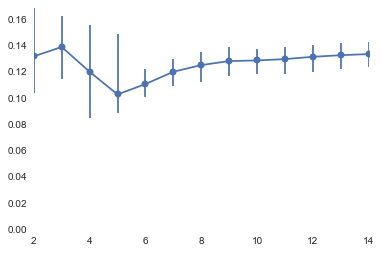

In [25]:
asymmetric_error = [boot_ci['mean'] - boot_ci['low_ci'], boot_ci['hi_ci']-boot_ci['mean']]

fig, ax = plt.subplots()
ax.errorbar(boot_ci['n_clusters'], boot_ci['mean'], yerr=asymmetric_error, fmt='-o')

plt.ylim(0, 0.17)
plt.show()

In [51]:
boot_ci

,n_clusters,hi_ci,low_ci,mean
0,2,0.169192,0.109660,0.132412
1,3,0.159301,0.106458,0.136818
2,4,0.167638,0.082985,0.113314
3,5,0.109374,0.089939,0.099886
4,6,0.118902,0.099616,0.111048
5,7,0.128619,0.110381,0.121106
6,8,0.135323,0.112770,0.125553
7,9,0.139341,0.120424,0.127874
8,10,0.137104,0.112136,0.128415
9,11,0.134669,0.116297,0.128268
